In [2]:
! pip install torch

     -------------------------------------- 167.3/167.3 MB 1.8 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


import numpy as np
import pandas as pd

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import nltk
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt

C:\Users\Sreelaxmi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
C:\Users\Sreelaxmi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\Sreelaxmi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: Depre

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sreelaxmi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [5]:
train_path = "train.csv"
test_path = "test.csv"

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [101]:
train_df = pd.read_csv(train_path)

In [102]:
test_df = pd.read_csv(test_path)


In [103]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [104]:
train_df = train_df.drop(columns=["textID"])
train_df = train_df.dropna()
train_df = train_df[train_df['text'] != "Not Available"]
train_df = train_df[['text', 'sentiment']]
train_df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [105]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [106]:
test_df = test_df.drop(columns=["textID"])
test_df = test_df.dropna()
test_df = test_df[test_df['text'] != "Not Available"]
test_df.head()

,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive


In [107]:
train_df['sentiment'].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [108]:


remove_pos = 8582 - 7781
remove_neut = 11117 - 7781

neg_df = train_df[train_df["sentiment"] == "negative"] 

pos_df = train_df[train_df["sentiment"] == "positive"]
neut_df = train_df[train_df["sentiment"] == "neutral"]

pos_drop_indices = np.random.choice(pos_df.index, remove_pos, replace=False)
neut_drop_indices = np.random.choice(neut_df.index, remove_neut, replace=False)

pos_undersampled = pos_df.drop(pos_drop_indices)
neut_undersampled = neut_df.drop(neut_drop_indices)

In [109]:
balanced_train_df = pd.concat([neg_df, pos_undersampled, neut_undersampled])


In [110]:
balanced_train_df["sentiment"].value_counts()

negative    7781
neutral     7781
positive    7781
Name: sentiment, dtype: int64

In [111]:
train_clean_df, test_clean_df = train_test_split(balanced_train_df, test_size=0.15)

In [112]:
train_clean_df.head()

,text,sentiment
7675,alright - was only joking - I just said no wi...,negative
21353,Nothing good at the five dollar sale.,negative
24419,_ashley OH REALLY?!,neutral
26815,i`m so glad,positive
25533,Have to go to work typical sunshine and deep ...,negative


In [113]:
train_set = list(train_clean_df.to_records(index=False))
test_set = list(test_clean_df.to_records(index=False))

In [114]:
def remove_links_mentions(tweet):
    link_re_pattern = "https?:\/\/t.co/[\w]+"
    mention_re_pattern = "@\w+"
    tweet = re.sub(link_re_pattern, "", tweet)
    tweet = re.sub(mention_re_pattern, "", tweet)
    return tweet.lower()

In [115]:
train_set = [(label, word_tokenize(remove_links_mentions(text))) for label, text in train_set]

In [116]:
test_set = [(label, word_tokenize(remove_links_mentions(tweet))) for label, tweet in test_set]

In [117]:
index2word = ["<PAD>", "<SOS>", "<EOS>"]

for ds in [train_set, test_set]:
    for label, tweet in ds:
        for token in tweet:
            if token not in index2word:
                index2word.append(token)

In [118]:
word2index = {token: idx for idx, token in enumerate(index2word)}

In [119]:
def label_map(label):
    if label == "negative":
        return 0
    elif label == "neutral":
        return 1
    else: #positive
        return 2

In [120]:
seq_length = 32

In [121]:
def encode_and_pad(tweet, length):
    sos = [word2index["<SOS>"]]
    eos = [word2index["<EOS>"]]
    pad = [word2index["<PAD>"]]

    if len(tweet) < length - 2: # -2 for SOS and EOS
        n_pads = length - 2 - len(tweet)
        encoded = [word2index[w] for w in tweet]
        return sos + encoded + eos + pad * n_pads 
    else: # tweet is longer than possible; truncating
        encoded = [word2index[w] for w in tweet]
        truncated = encoded[:length - 2]
        return sos + truncated + eos

In [122]:
train_encoded = [(encode_and_pad(tweet, seq_length), label_map(label)) for label, tweet in train_set]

In [123]:
test_encoded = [(encode_and_pad(tweet, seq_length), label_map(label)) for label, tweet in test_set]


In [124]:
for i in train_encoded[:3]:
    print(i)

([1, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2)
([1, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2)
([1, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2)


In [125]:
batch_size = 50

train_x = np.array([tweet for tweet, label in train_encoded])
train_y = np.array([label for tweet, label in train_encoded])
test_x = np.array([tweet for tweet, label in test_encoded])
test_y = np.array([label for tweet, label in test_encoded])

train_y = train_y.type(torch.LongTensor)

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))


# train_ds
# train_ds = train_ds.type(torch.LongTensor)

train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [97]:
class BiLSTM_SentimentAnalysis(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout) :
        super().__init__()

        # The embedding layer takes the vocab size and the embeddings size as input
        # The embeddings size is up to you to decide, but common sizes are between 50 and 100.
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM layer takes in the the embedding size and the hidden vector size.
        # The hidden dimension is up to you to decide, but common values are 32, 64, 128
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # We use dropout before the final layer to improve with regularization
        self.dropout = nn.Dropout(dropout)

        # The fully-connected layer takes in the hidden dim of the LSTM and
        #  outputs a a 3x1 vector of the class scores.
        self.fc = nn.Linear(hidden_dim, 3)

    def forward(self, x, hidden):
        """
        The forward method takes in the input and the previous hidden state 
        """

        # The input is transformed to embeddings by passing it to the embedding layer
        embs = self.embedding(x)

        # The embedded inputs are fed to the LSTM alongside the previous hidden state
        out, hidden = self.lstm(embs, hidden)

        # Dropout is applied to the output and fed to the FC layer
        out = self.dropout(out)
        out = self.fc(out)

        # We extract the scores for the final hidden state since it is the one that matters.
        out = out[:, -1]
        return out, hidden
    
    def init_hidden(self):
        return (torch.zeros(1, batch_size, 32), torch.zeros(1, batch_size, 32))

In [98]:
model = BiLSTM_SentimentAnalysis(len(word2index), 64, 32, 0.2)
model = model.to(device)


In [99]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)

In [ ]:
train_dl

In [100]:
epochs = 50
losses = []
for e in range(epochs):

    h0, c0 =  model.init_hidden()

    h0 = h0.to(device)
    c0 = c0.to(device)

    for batch_idx, batch in enumerate(train_dl):

        input = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model(input, (h0, c0))
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
    losses.append(loss.item())

RuntimeError: expected scalar type Long but found Int

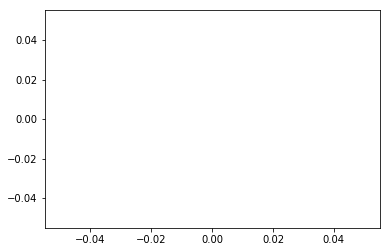

In [70]:
plt.plot(losses)

In [71]:
batch_acc = []
for batch_idx, batch in enumerate(test_dl):

    input = batch[0].to(device)
    target = batch[1].to(device)

    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        out, hidden = model(input, (h0, c0))
        _, preds = torch.max(out, 1)
        preds = preds.to("cpu").tolist()
        batch_acc.append(accuracy_score(preds, target.tolist()))

sum(batch_acc)/len(batch_acc)

1.0